# Coarse-grained order parameter

We will calculate the coarse-grained order parameter of phospholipids in a ternary mixture of DPPC, DOPC, and Cholesterol simulated by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3).

We will use the class `liyphilic.lib.order_parameter.SCC` to calculate the coarse-grained order parameter, as defined in [Seo et al. (2020)](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.0c01317). We will then project the $S_{CC}$ onto the membrane plane, creating a two-dimensional heatmap coloured by the $S_{CC}$ value.

The coarse-grained order parameter, $S_{CC}$, is defined as:
$$
S_{CC} = \displaystyle \frac{\big \langle 3 \cos^2 \theta - 1 \big \rangle}{2}
$$

where $\theta$ is the angle between the membrane normal and the vector connecting two consecutive tail beads. Angular brackets denote averages over all beads in an acyl tail.

The $S_{CC}$ range from -0.5 to 1. **Values nearer zero indicate more disordered tails.**

Note
---- 

See [Piggot et al. (2017)](https://pubs.acs.org/doi/full/10.1021/acs.jctc.7b00643) for an excellent discussion on calculating acyl tali order parameters in molecular dynamics simulations.


In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
from lipyphilic.lib.order_parameter import SCC


## Load the topology and trajectory using MDAnalysis

In [2]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

## Calculate $S_{CC}$ of sn-1 tails

To calculate the order parameter, we need to pass our universe to `SCC` along with an atom seletion defining the atoms to use in the calculation:


In [3]:
scc_sn1 = SCC(
    universe = u, 
    tail_sel = "name ??A"
)


Our `tail_sel` makes use of the powerful selection language of MDAnalysis. '??A' will select any atom that starts with any two characters and ends with 'A'. In the MARTINI force field, this corresponds to the $sn-1$ tails of lipids.

In our case, this selection will select the following beads: 'C1A', 'C2A', 'D2A', 'C3A', and 'C4A'.

We then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`)::


In [4]:
scc_sn1.run(start=None, stop=None, step=None, verbose=True)


  0%|          | 0/51 [00:00<?, ?it/s]

Warning
-------

`tail_sel` should select beads in **either** the *sn1* **or** *sn2* tails, not both tails.


## Accessing the results

The results are then available in the `scc_sn1.SCC` attribute as a `numpy.ndarray`. The array has the shape ($N_{\rm lipids}$, $N_{\rm frames}$). Each row
corresponds to an individual lipid and each column to an individual frame.


In [5]:
# There are 8000 phospholipids in our membrane, and 51 frames in our trajectory
scc_sn1.SCC.shape

(8000, 51)

## Calculate $S_{CC}$ of sn-2 tails

Likewise, to calculate the $S_{CC}$ of the *sn2* tails, we can do:



In [6]:
scc_sn2 = SCC(
    universe = u, 
    tail_sel = "name ??B"
)


In this caase, '??B' will select 'C1B', 'C2B', 'D2B', 'C3B', and 'C4B'.

Again, we then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`)::


In [7]:
scc_sn2.run(start=None, stop=None, step=None, verbose=True)


  0%|          | 0/51 [00:00<?, ?it/s]

## Calculate a weighted average $S_{CC}$ over the two tails

To calculate a weighted-average $S_{CC}$ we can do use the `weighted_average` method of `SCC`:

In [8]:
scc = SCC.weighted_average(scc_sn1, scc_sn2)

This function takes into account the number of beads in each tail and return a new `SCC`object whose `SCC` attribute contains the weighted-average $S_{CC}$ for each lipid at each frame.

# Project the $S_{CC}$ values onto the membrane plane


## Load the leaflet information


We want to project the $S_{CC}$ values of lipids in the upper leaflet onto the membrane plane. For this, we first need to know which leaflet each lipid is in at each frame. We will use the results from the notebook on [assigning lipids to leaflets](2-AssignLeaflets.ipynb).


In [9]:
with open("../results/leaflets/leaflets-dppc-dopc-chol.pkl", 'rb') as f:
    leaflets = pickle.load(f)
    

`leaflets` contains the leaflet membership of every lipid at each frame, including cholesterol.

Values of:
- -1 indicate the lipid is in the lower leaflet
- 1 indicate the lipid is in the upper leaflet

We will make use to the `filter_leaflets` method to obtain the leaflet membership of the phospholipids only:



In [10]:
phospholipid_leaflets = leaflets.filter_leaflets(
    lipid_sel="resname DPPC DOPC"
)


We will now create a boolean mask based on leaflet membership that can be used to select lipids in the upper leaflet only:

In [11]:
leaflet_mask = (phospholipid_leaflets == 1)

In [12]:
leaflet_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Create our plotting object

We will use `scc.project_SCC` to caclulate $S_{CC}$ as a function of $xy$ positions and generate an initial plot.


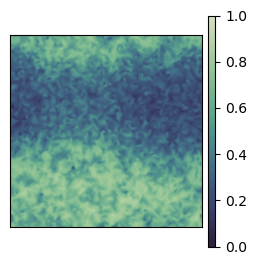

In [13]:
scc_UL = scc.project_SCC(
    lipid_sel="name GL1 GL2",  # select phospholipid atoms for calculating the COM of each lipid
    filter_by=leaflet_mask,    # use only lipids in the upper leaflet
    start=-20                  # use Scc values from 100 frames from the end onwards, otherwise the whole trajectory will be used
)


## Adjusting the aesthetics

There are many options that we can use to control the aesthetics of out plot. Below we will look at some of these options.

**We can change the aesthetics of our plot without creating a new object - we simply need to call `plot_projection` again**


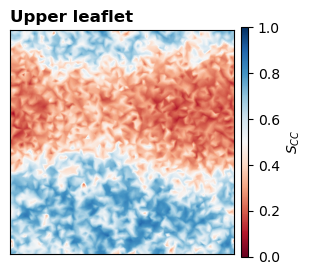

In [14]:
# set the size of our plot (in inches)
fig, ax = plt.subplots(1, figsize=(3.5, 3.5))

scc_UL.plot_projection(
    ax=ax,                  # where to plot the plot
    title="Upper leaflet",
    vmin=0.0,               # colourbar maximum value
    vmax=1,                 # colourbar minimum value
    cmap="RdBu",            # colourmap to use
    cbar_kws={"shrink": 0.85, "label": r"$S_{CC}$"}  # make the colourbar smaller and give it a label
)


In this membrane, there is a clear separation between $L_o$ regions with ordered acyl tails (large $S_{CC}$ values) and $L_d$ regions with disordered acyl tails (small $S_{CC}$ values).